In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import subprocess

import random
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

from tqdm import tqdm
from prettytable import PrettyTable

Using TensorFlow backend.


In [2]:
tqdm.pandas()

## Data Pre-processing

In [3]:
# GLOBAL PATH VARIABLE FOR AUDIO / TXT FILES:
path = 'respiratory-sound-database/audio_and_txt_files/'

In [4]:
def get_audio_files():
    folder = os.listdir(path)

    wav_files, txt_files = [], []
    for file in folder:
        if file.endswith('_16.wav'):
            wav_files.append(file)
        elif file.endswith('.txt'):
            txt_files.append(file)
    
    print("Sanity Check for Array Lengths: {}, {}".format(len(wav_files), len(txt_files)))
    return wav_files, txt_files

In [5]:
def extract_info(filename):
    splits = filename.split('_')
    print(splits)

In [6]:
# separate files by audio and txt
wav_files, txt_files = get_audio_files()
wav_files = sorted(wav_files)
txt_files = sorted(txt_files)

Sanity Check for Array Lengths: 830, 830


In [7]:
# extract information from the wav files' filename
# 0:[patient #], 1:[recording index], 2:[chest location], 3:[acquisition mode], 4:[recording equipment]
stripped_file_info = [re.sub('_16\.wav$', '', file) for file in wav_files]
file_info = [file.split('_') for file in stripped_file_info]

In [8]:
# load the extracted data into a dataframe
demog_data = pd.read_csv('demographic-info.csv')
diag_data = pd.read_csv('respiratory-sound-database/patient_diagnosis.csv', names=['Patient Number', 'Diagnosis'])
data = pd.DataFrame(data=file_info, 
                    columns=['Patient Number', 'Recording Index', 'Chest Location', 'Acquisition Mode', 'Recording Equipment'])

data['Patient Number'] = data['Patient Number'].astype(int)
data['txt_file'] = txt_files
data['audio_file'] = wav_files

In [9]:
# put info from demog_data into data
age, sex, a_BMI, c_weight, c_height, diagnosis = [], [], [], [], [], []
demog_size = demog_data['Age'].size
size = data['Patient Number'].size

In [10]:
# TODO: Make this more efficient
conversions = {'COPD':0, 'Pneumonia':1, 'Healthy':2, 'URTI':3, 'Bronchiectasis':4, 'Bronchiolitis':5, 'LRTI':6, 'Asthma':7}

for j in tqdm(range(0, size)):
    for i in range(0, demog_size):
        if data['Patient Number'][j] == demog_data['Patient Number'][i]:
            age.append(demog_data['Age'][i])
            sex.append(demog_data['Sex'][i])
            a_BMI.append(demog_data['Adult BMI'][i])
            c_weight.append(demog_data['Child Weight'][i])
            c_height.append(demog_data['Child Height'][i])
        if data['Patient Number'][j] == diag_data['Patient Number'][i]:
            diagnosis.append(conversions[diag_data['Diagnosis'][i]])
        pass

100%|██████████| 830/830 [00:04<00:00, 170.64it/s]


In [11]:
data['Age'], data['Sex'], data['Adult BMI'], data['Child Weight'], data['Child Height'], data['Diagnosis'] = age, sex, a_BMI, c_weight, c_height, diagnosis

In [12]:
sample_rates = []
unique_sample_rates = set()

In [13]:
# find the lowest sampling rate
lowest = np.inf

for f in tqdm(data['audio_file']):
    sample_rate, samples = wavfile.read(path + f)
    sample_rates.append(sample_rate)
    unique_sample_rates.add(sample_rate)
    if sample_rate < lowest:
        lowest = sample_rate

print(lowest)

100%|██████████| 830/830 [00:00<00:00, 2028.82it/s]8000



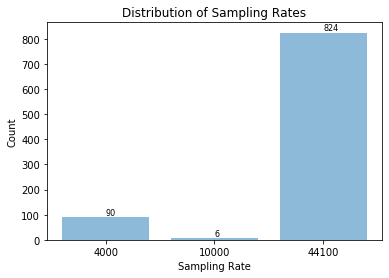

In [81]:
# create a distribution of sample rates
bar_objects = list(unique_sample_rates)
y_pos = np.arange(len(bar_objects))
bar_object_counts = [sample_rates.count(obj) for obj in bar_objects]

plt.bar(y_pos, bar_object_counts, align='center', alpha=0.5)
plt.xticks(y_pos, bar_objects)
plt.ylabel('Count')
plt.xlabel('Sampling Rate')
plt.title('Distribution of Sampling Rates')

for i in range(len(bar_object_counts)):
    plt.text(x=i, y=bar_object_counts[i] + 10, s=str(bar_object_counts[i]), size=8)

plt.show()

In [14]:
# function to get spectrogram from a wav file
def get_spectro(file_path):
    sample_rate, samples = wavfile.read(path + file_path)
    vector, freqs, bins, im = plt.specgram(samples[:], NFFT=1024, Fs=8000, noverlap=900)
    return vector

100%|██████████| 830/830 [00:48<00:00, 16.94it/s]


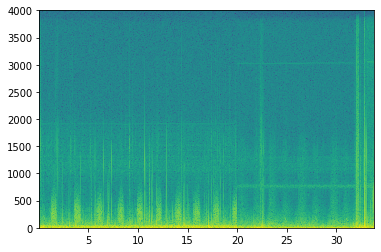

In [15]:
spec_vecs = []
sizes = []
for f in tqdm(data['audio_file']):
    spectrogram_vector = get_spectro(f)
    # print(spectrogram_vector.shape)

    # Padding as per CNN bug
    # without padding, max size is (513, 2773)
    # padded_spec_vec = np.zeros((513, 2773))
    # padded_spec_vec[:spectrogram_vector.shape[0],:spectrogram_vector.shape[1]] = spectrogram_vector
    
    # sizes.append(padded_spec_vec.shape)
    sizes.append(spectrogram_vector.shape)
    # spec_vecs.append(padded_spec_vec)
    spec_vecs.append(spectrogram_vector)

In [16]:
size_counts = dict()
for s in sizes:
    if s not in size_counts.keys():
        size_counts[s] = sizes.count(s)

most_common_size = max(size_counts, key=lambda s: size_counts[s])
most_common_size_count = size_counts[most_common_size]
print("Most common shape is {} at a count of {}.".format(most_common_size, most_common_size_count))
comm_shape = most_common_size[1]

Most common shape is (513, 1283) at a count of 817.


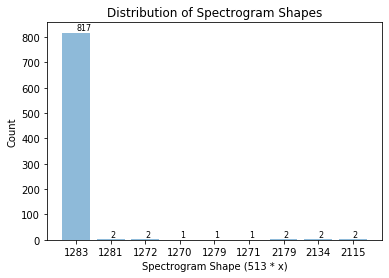

In [17]:
# create a distribution of spectrogram shapes
bar_objects = [s[1] for s in size_counts.keys()]
y_pos = np.arange(len(bar_objects))
bar_object_counts = [size_counts[s] for s in size_counts.keys()]

plt.bar(y_pos, bar_object_counts, align='center', alpha=0.5)
plt.xticks(y_pos, bar_objects)
plt.ylabel('Count')
plt.xlabel('Spectrogram Shape (513 * x)')
plt.title('Distribution of Spectrogram Shapes')

for i in range(len(bar_object_counts)):
    plt.text(x=i, y=bar_object_counts[i] + 10, s=str(bar_object_counts[i]), size=8)

plt.show()

In [18]:
def truncate_array(arr, x, y):
    temp = np.zeros((x, y))
    for i in range(0, x):
        for j in range(0, y):
            temp[i][j] = arr[i][j]
    return temp

In [19]:
for i in range(0, len(spec_vecs)):
    # Padding as per CNN bug
    # without padding, most common size is (513, 637)
    padded_sv = np.zeros((513, 1283))

    if spec_vecs[i].shape[1] < 1283:
        padded_sv[:spec_vecs[i].shape[0], :spec_vecs[i].shape[1]] = spec_vecs[i]
        spec_vecs[i] = padded_sv
    elif spec_vecs[i].shape[1] > 1283:
        padded_sv = truncate_array(spec_vecs[i], 513, 1283)
        spec_vecs[i] = padded_sv

In [20]:
data['Spectrogram'] = spec_vecs
print(data.shape)
print(data.columns)
data.iloc[0].Spectrogram.shape

(830, 14)
Index(['Patient Number', 'Recording Index', 'Chest Location',
       'Acquisition Mode', 'Recording Equipment', 'txt_file', 'audio_file',
       'Age', 'Sex', 'Adult BMI', 'Child Weight', 'Child Height', 'Diagnosis',
       'Spectrogram'],
      dtype='object')


(513, 1283)

## CNN ##

In [21]:
# Split Indices
data_size = len(data)
test_per = 0.10
val_per = 0.20

data_ind = np.arange(data_size)
random.shuffle(data_ind)
train_ind, val_ind, test_ind = np.split(data_ind, [int(1 - val_per*data_size-test_per*data_size), int(1-test_per*data_size)])

train_ind = sorted(train_ind)
val_ind = sorted(val_ind)
test_ind = sorted(test_ind)

print("Total Data Size: {}".format(data_size))
print("Train Size: {}".format(len(train_ind)))
print("Tain Size: {}".format(len(test_ind)))
print("Val Size: {}".format(len(val_ind)))

Total Data Size: 830
Train Size: 582
Tain Size: 82
Val Size: 166


In [22]:
# Split Data

x_cols = ['Spectrogram']
y_cols = ['Diagnosis']

x_train = data.iloc[train_ind, :]
x_train = np.asarray(x_train['Spectrogram'].tolist())

x_val = data.iloc[val_ind, :]
x_val = np.asarray(x_val['Spectrogram'].tolist())

x_test = data.iloc[test_ind, :]
x_test = np.asarray(x_test['Spectrogram'].tolist())

y_train = data.iloc[train_ind, :]
y_train = np.asarray(y_train['Diagnosis'].tolist())

y_val = data.iloc[val_ind, :]
y_val = np.asarray(y_val['Diagnosis'].tolist())

y_test = data.iloc[test_ind, :]
y_test = np.asarray(y_test['Diagnosis'].tolist())

print("Sizes: \n Train x: {}, Train y: {}\n Val x: {}, Val y: {}\n Test x: {}, Test y: {}"
      .format(len(x_train), len(y_train), len(x_val), len(y_val), len(x_test), len(y_test)))

Sizes: 
 Train x: 582, Train y: 582
 Val x: 166, Val y: 166
 Test x: 82, Test y: 82


In [23]:
print(x_train[0].shape)
print(y_train[0])

(513, 1283)
2


In [29]:
# Building Model

# reshape for the network

MAX_TIME = 513
MAX_FRQ = 1283 # 2773
normalizer = 1

x_train = x_train.reshape(len(x_train), MAX_TIME, MAX_FRQ, 1) / normalizer
x_val = x_val.reshape(len(x_val), MAX_TIME, MAX_FRQ, 1) / normalizer
x_test = x_test.reshape(len(x_test), MAX_TIME, MAX_FRQ, 1) / normalizer

# create a linear stack of layers
# see: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
model = models.Sequential()

# first layer is a convolutional layer:
#   - 32 filters (or kernels)
#   - kernel width of 3x3
#   - relu (rectified linear unit) activation
#   - input shape (from the data)
#   - see for more options: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(MAX_TIME, MAX_FRQ, 1), name="layer1"))

# max pooling2
#   - argument describes how much to downsample the data (by a factor of 2 in both dimensions)
#   - see for more options: https://keras.io/layers/pooling/
model.add(layers.MaxPooling2D((2, 2), name="layer2"))

# convolution (same kernel size)
# model.add(layers.Conv2D(64, (3,3), activation='relu', name="layer3"))

# max pooling
# model.add(layers.MaxPooling2D((2, 2), name="layer4"))

# convolution layer
# model.add(layers.Conv2D(64, (3,3), activation='relu', name="layer5"))

# flatten
model.add(layers.Flatten())

# dense
# model.add(layers.Dense(64, activation='relu'))

# the final number of outputs (one for each class)
model.add(layers.Dense(8))

# compile the model
# using:
#   - the adam optimizer (see for more info: https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)
#   - categorical cross entropy (also know as: softmax!)
#   - accuracy as the metric (FIXME)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
# CHECKING DATA TYPES AS PER TF ERROR

ls = [type(item) for item in x_train]
# print(ls)
d = {i:ls.count(i) for i in set(ls)}
print(d)

# y_train
ls = [type(item) for item in y_train]
# print(ls)
d = {i:ls.count(i) for i in set(ls)}
print(d)

# x_val
ls = [type(item) for item in x_val]
# print(ls)
d = {i:ls.count(i) for i in set(ls)}
print(d)

# y_val
ls = [type(item) for item in y_val]
# print(ls)
d = {i:ls.count(i) for i in set(ls)}
print(d)

print(data.info())

{<class 'numpy.ndarray'>: 582}
{<class 'numpy.int64'>: 582}
{<class 'numpy.ndarray'>: 166}
{<class 'numpy.int64'>: 166}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 830 entries, 0 to 829
Data columns (total 14 columns):
Patient Number         830 non-null int64
Recording Index        830 non-null object
Chest Location         830 non-null object
Acquisition Mode       830 non-null object
Recording Equipment    830 non-null object
txt_file               830 non-null object
audio_file             830 non-null object
Age                    824 non-null float64
Sex                    824 non-null object
Adult BMI              753 non-null object
Child Weight           70 non-null object
Child Height           67 non-null float64
Diagnosis              830 non-null int64
Spectrogram            830 non-null object
dtypes: float64(2), int64(2), object(10)
memory usage: 90.9+ KB
None


In [31]:
print(tf.shape(x_train))

tf.Tensor([ 582  513 1283    1], shape=(4,), dtype=int32)


In [1]:
# Training Model
# how many epochs (passes through the data)
num_epochs = 5

# this will hold the performance
perf_time = np.zeros((num_epochs, 3))

# set up figure
fig = plt.figure()
ax1 = fig.add_subplot(111)

# training the network for num_epoch epochs
for epoch in tqdm(range(0,num_epochs)):
    # train an epoch at a time, visualize as we go!
    model.fit(x_train, y_train, batch_size=128, epochs=1, verbose=2, validation_data=(x_val, y_val))
    
    # check ty_trainormance on train/test/val
    # the model.evaluate function returns the loss (position 0) and the performance (position 1)
    new_perf = [model.evaluate(x_train, y_train)[1], model.evaluate(x_val, y_val)[1], model.evaluate(x_test, y_test)[1]]
    
    # add to performance
    perf_time[epoch,:] = new_perf
    
    # visualize
    plt.plot(np.arange(0,epoch+1),perf_time[0:epoch+1,0],'b', label='train')
    plt.plot(np.arange(0,epoch+1),perf_time[0:epoch+1,1],'r', label='validation')
    plt.plot(np.arange(0,epoch+1),perf_time[0:epoch+1,2],'g', label='test')
    plt.legend(loc='upper left')
    plt.show()

perf_table = PrettyTable()
perf_table.field_names = ["Train Accuracy", "Val Accuracy", "Test Accuracy"]
for epoch in np.arange(0, num_epochs):
    perf_table.add_row(perf_time[epoch])

NameError: name 'np' is not defined